## Model Complexity and Model Selection

## KNN Regressor



### I. Implementing $k$-NN Regressor

In this part, I used the `scikit-learn` convention to build a $k$-NN regressor:
- `__init__` method to initalize the hyper-parameter $k$, 
- `fit` method to train the model using a training dataset, and 
- `predict` method to estimate unknown data using the trained estimator, i.e. we have to use `fit` first before using `predict`.

Inheriting from `BaseEstimator`, I use similar implementation as the $k$-NN classifier for `__init__` and `fit` method, but with a little tweak in the `predict` method. 

Unlike in $k$-NN classifier where we find the mode of the labels, in $k$-NN regressor we compute the average of the neighbour's values and return it.

In [2]:
from sklearn.base import BaseEstimator
from scipy.spatial import KDTree

class KnnRegressor(BaseEstimator):

    def __init__(self, k):
        self.k = k 

    def fit(self, x, y):
        self.y_train_ = y
        self.x_train_kdtree_ = KDTree(x)
        return self
    
    def predict(self, x):
        _, neighbours = self.x_train_kdtree_.query(x, k=self.k) # find the k nearest neighbors and their distances
        neighbours = neighbours.reshape(len(x), self.k)
        neighbour_target = self.y_train_[neighbours] # get the targets
        avg_values = np.mean(neighbour_target, axis=1)
        return avg_values

##### Prepare `diabetes` Dataset 

To test the regressor, I load the `diabetes` dataset and check the `'data'` and `'target'` shape. I also split the data into training and test dataset using the following `train_test_split` function with `'train_size'` equal to 0.7. 

In [3]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
diabetes.data.shape, diabetes.target.shape, diabetes.feature_names

((442, 10),
 (442,),
 ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'])

In [4]:
diabetes.data[:5]

array([[ 0.03807591,  0.05068012,  0.06169621,  0.02187239, -0.0442235 ,
        -0.03482076, -0.04340085, -0.00259226,  0.01990749, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, -0.02632753, -0.00844872,
        -0.01916334,  0.07441156, -0.03949338, -0.06833155, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, -0.00567042, -0.04559945,
        -0.03419447, -0.03235593, -0.00259226,  0.00286131, -0.02593034],
       [-0.08906294, -0.04464164, -0.01159501, -0.03665608,  0.01219057,
         0.02499059, -0.03603757,  0.03430886,  0.02268774, -0.00936191],
       [ 0.00538306, -0.04464164, -0.03638469,  0.02187239,  0.00393485,
         0.01559614,  0.00814208, -0.00259226, -0.03198764, -0.04664087]])

In [5]:
diabetes.target[:5]

array([151.,  75., 141., 206., 135.])

In [6]:
import numpy as np


def train_test_split(x, y, train_size=0.7, random_state=None):
    RNG = np.random.default_rng(random_state)
    N = len(x)
    N_train = round(N*train_size)
    idx_train = RNG.choice(N, N_train, replace=False)
    idx_test = np.setdiff1d(np.arange(N), idx_train)
    RNG.shuffle(idx_test)
    return x[idx_train],x[idx_test],y[idx_train],y[idx_test]

x_train, x_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, train_size=0.7, random_state=1)

### II. Test the $k$-NN Regressor

Now that we have prepared the data, we can test our regressor with following steps:
 - fit the data with a random $k$, 
 - use the trained model to predict the target values,
 - use **Root Mean Squared Error (RMSE)** to measure the training and testing errors.

At first I fit the data using a rather small $k$ (e.g. under 5), but the train and test errors seem to be relatively so far apart, so then I tried to find the $k$ that will minimize the test error. After I find the RMSE for different values of $k$ (maximum $k$ = 50) and plot it, it seems like $k=21$ is the most optimal in this case. Thus the training and test error for this $k$ is given below.

In [16]:
knn = KnnRegressor(k=21)
knn.fit(x_train,y_train)
y_hat_test = knn.predict(x_test)
y_hat_train = knn.predict(x_train)

In [18]:
from sklearn.metrics import mean_squared_error

def RMSE(y, y_hat):
    mse = mean_squared_error(y,y_hat)
    return np.sqrt(mse)

y_hat_train = knn.predict(x_train)
print(f"Training Error:",RMSE(y_train, y_hat_train)) 
print(f"Test Error:",RMSE(y_test, y_hat_test))

Training Error: 54.6062211767502
Test Error: 57.512689859069354


## L-Fold Cross Validation

### I. Implementing L-Fold Cross Validation

In this question, I use the `scikit-learn` convention for data splitters to build the $k$-fold cross validation:
- `get_n_splits` to inform the number of split the splitter would produce for the given dataset
- `split` which yield a sequence of training and test indices.

In [49]:
from numpy import concatenate, array_split

class LFold:
    def __init__(self, L, random_state = None):
        self.RNG = np.random.default_rng(random_state)
        self.L = L

    def get_n_splits(self, x=None, y=None, groups=None):
        return self.L
    
    def split(self, x, y=None, groups = None):
        num_of_samples = len(x)
        x_indices = np.arange(num_of_samples)
        fold_groups = np.array_split(x_indices,self.L)
        for _ in range(self.L):
            test_idx = fold_groups[_].copy()
            train_idx = np.concatenate([fold_groups[j] for j in range(self.L) if j != _])  # Train fold indices
            self.RNG.shuffle(test_idx)
            yield train_idx, test_idx
 

Then I test the implementation by running a simple example as follows, it shows that it gives the indices of the training and test dataset correctly, with shuffled test indices.

In [50]:
for idx_train, idx_test in LFold(5).split(list(range(20))):
    print(idx_train, idx_test)

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [2 0 1 3]
[ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19] [5 7 4 6]
[ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19] [11  9 10  8]
[ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19] [14 12 13 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [16 19 17 18]


### II. Test the Effect of the KNN Parameter K

In this part, I use the L-fold CV implementation to test the effect of $k$, the $k$-NN parameter with the following steps:
- For each $k$ from 1 to 30, I ran the L-fold cross validation using the built-in `cross_validate` function from `scikit-learn`.
- store the mean and standard deviation of the mean squared error of both the training and test dataset. 

To do this, I implement the function `evaluation` that encapsulate this experiment and return the result in lists.

I found that the $k$ with the best test performance (e.g. the test error with the lowest mean) is $k=19$.


In [72]:
## Application to Test the Effect of $k$ in $k$-NN
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

def evaluation(max_k, cv):
    # Initialize lists to store the result
    test_results = np.zeros(shape =(max_k,2))
    train_results = np.zeros(shape = (max_k,2))
    
    # Cross validation and compute the mean and standar error
    for k in range(1, max_k+1):
        knn = KnnRegressor(k)
        cv_res = cross_validate(knn, diabetes.data, diabetes.target, cv=cv, return_train_score=True, scoring=make_scorer(mean_squared_error))
        test_results[k-1,0] = np.mean(cv_res['test_score'])
        train_results[k-1,0] = np.mean(cv_res['train_score'])
        test_results[k-1,1] = np.std(cv_res['test_score'])
        train_results[k-1,1] = np.std(cv_res['train_score'])

    return train_results, test_results

# Test all K with L-Fold CV and store the score of training and test dataset
L=5
max_k=30
train_results, test_results = evaluation(max_k=max_k, cv=LFold(L))

# Find the K with the best test performance
optimal_k = np.argmin(test_results[:,0])+1
print(f'Most optimal k is {optimal_k}. For this k, the MSE is as follows:\nTrain MSE (mean={train_results[optimal_k-1, 0]:.4f}, std={train_results[optimal_k-1, 1]:.4f}) \nTest MSE (mean={test_results[optimal_k-1, 0]:.4f}, std={test_results[optimal_k-1, 1]:.4f})')

Most optimal k is 19. For this k, the MSE is as follows:
Train MSE (mean=2956.9833, std=49.9273) 
Test MSE (mean=3172.3750, std=188.3471)


### III. Plot the Mean Training and Test Errors Against the Choice of K

To visualize the effect of the choice of $k$ and L better, we plot the mean training and test errors against $k$ using error bars. This error bars will represent 95% confidence intervals and can be computed as follows

$$ m \pm \frac{1.96s}{\sqrt L}$$

where m is the sample mean and s is the sample standard deviation of the error across L folds. We can also call $\frac{s}{\sqrt L}$ as the *standard error of the mean*.

To do this, I implement the function `plot_knn_errors` which can be seen as an extension of the `evaluation` function above. This function does the following:
- similar to `evaluation` function above, it does cross validation and store the result in lists
- from the result of error of the training and test dataset, find the best $k$
- plot the MSE against the choice of $k$ using the error bars
- return the best $k$.

We run this function for different choices of L to see the effect of L as well.

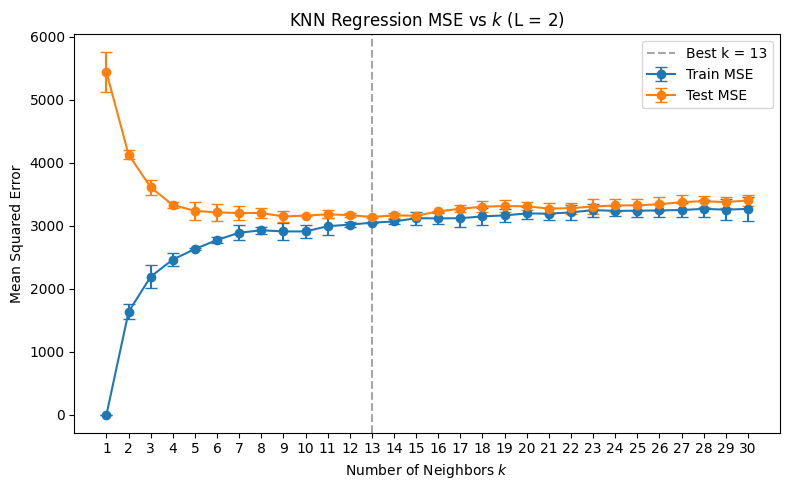

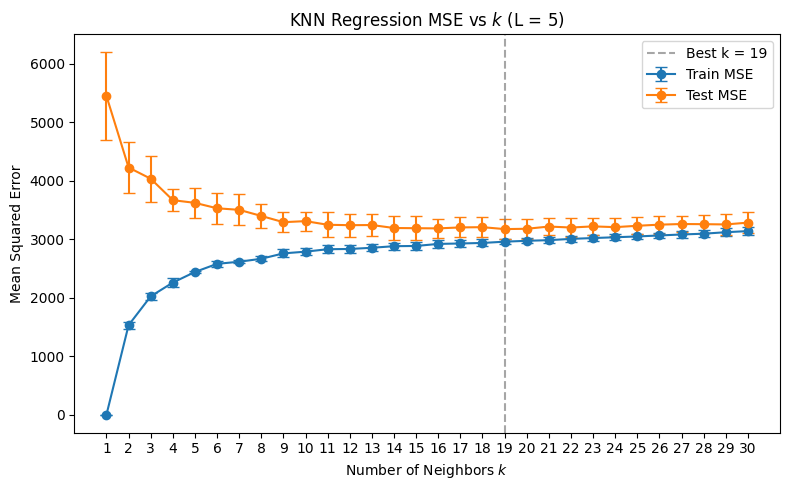

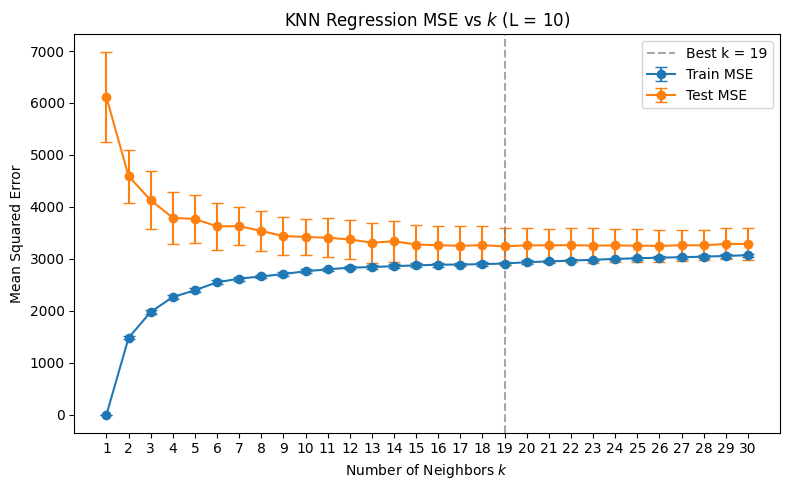

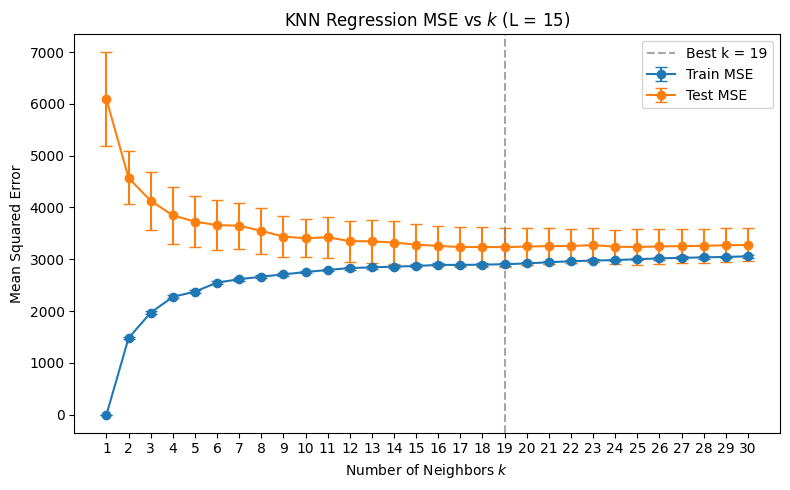

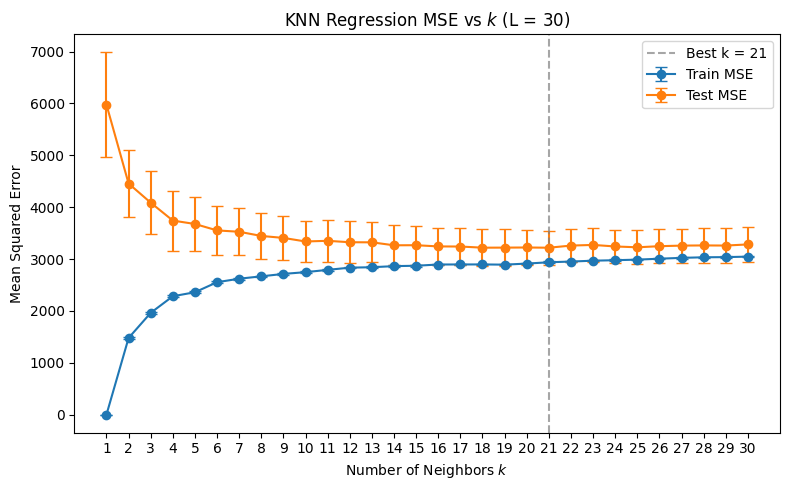

Best k for L=2 is 13
Best k for L=5 is 19
Best k for L=10 is 19
Best k for L=15 is 19
Best k for L=30 is 21


In [84]:
from matplotlib import pyplot as plt

def plot_knn_errors(L, max_k):
    # Initialize lists to store the result
    test_results = np.zeros((max_k, 2))   
    train_results = np.zeros((max_k, 2))

    # Cross validation and compute the mean and standar error
    for k in range(1, max_k + 1):
        knn = KnnRegressor(k)
        cv_res = cross_validate(
            knn,
            diabetes.data,
            diabetes.target,
            cv=LFold(L),
            return_train_score=True,
            scoring=make_scorer(mean_squared_error)
        )
        test_results[k - 1, 0] = np.mean(cv_res['test_score'])
        train_results[k - 1, 0] = np.mean(cv_res['train_score'])
        test_results[k - 1, 1] = np.std(cv_res['test_score'])
        train_results[k - 1, 1] = np.std(cv_res['train_score'])

    # Find the best k
    best_k = np.argmin(test_results[:, 0])

    # Initialization for plotting
    ks = np.arange(1, max_k + 1)
    conf_interval_scaler = 1.96/np.sqrt(L)  # std error denominator

    # Plot MSE vs k
    plt.figure(figsize=(8, 5))
    plt.errorbar(ks, train_results[:, 0], yerr=train_results[:, 1] * conf_interval_scaler,
                 label='Train MSE', fmt='o-', capsize=4)
    plt.errorbar(ks, test_results[:, 0], yerr=test_results[:, 1] * conf_interval_scaler,
                 label='Test MSE', fmt='o-', capsize=4)

    # Highlight best k
    plt.axvline(best_k + 1, linestyle='--', color='gray', alpha=0.7, label=f'Best k = {best_k + 1}')

    plt.title(f'KNN Regression MSE vs $k$ (L = {L})')
    plt.xlabel('Number of Neighbors $k$')
    plt.ylabel('Mean Squared Error')
    plt.xticks(ks)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return best_k

best_k_for_L = []
for L in [2,5,10,15,30]:
    plot_L = plot_knn_errors(L,max_k=30)
    best_k_for_L.append(plot_L + 1)
for i,L in enumerate([2,5,10,15,30]):
    print(f"Best k for L={L} is {best_k_for_L[i]}")

#### Analysis

**1. Effect of the parameter $k$** 

- When $k$ is low (e.g. under 10), there are signs of **overfitting** for every L, because of the gap between training and test error. The model is **highly flexible** and captures the noise in the training data (high variance)
- When $k$ increase, around the middle of the plot for each plot (e.g. $k$ between 13-21 depending on L), is where the best performance usually found because the model starts to **balance between bias and variance**.
- When $k$ is even higher (e.g. 20-30), usually the test error starts to stabilize, but the training error will be higher. This can indicates **underfitting**, reflecting the model being too **rigid** and averages over too many neighbours.

**2. Effect of the parameter L** 

- When L is small (e.g. 2, 5), the error bars for each $k$ are shorter than when L is large. This is especially shown when $k$ is also small, because the model is extremely flexible and has high variance
- When L is large, the test sets become smaller and **each fold has higher variances**, making the s smaller and therefore resulting in **smaller standard error of the mean** $\left(\frac{s}{\sqrt L}\right)$.

## Automatic Model Selection

### I. Implement an Automatic KNN Regressor

Using similar conventions as the previous regressors, now we implement a $k$-NN regressor that can choose the best $k$ automatically by performing cross validation while fitting the training dataset. I do this as following:
- use the built in `cross_validate` function and the previous `LFold` cross validation splitter,
- find the lowest mean test score from all $k$
- for `predict` method, use the basic `KnnRegressor`.

In [56]:
class KnnRegressorCV(BaseEstimator):
    def __init__(self, ks=list(range(1, 21)), cv=LFold(5)):
        self.ks = ks
        self.cv = cv
        self.k_ = None #to store the best k

    def fit(self, x, y):
        self.y_train = y
        self.x_train = x
        best_k = None
        best_score = float('inf')
        for k in self.ks:
            knn = KnnRegressor(k)
            cv_res = cross_validate(knn, x, y, cv=self.cv, scoring=make_scorer(mean_squared_error))
            if np.mean(cv_res['test_score']) <= best_score:
                best_score = np.mean(cv_res['test_score'])
                best_k = k
        self.k_ = best_k
        return self
    
    def predict(self, x):
        return KnnRegressor(self.k_).fit(self.x_train,self.y_train).predict(x)

### II. Test `KnnRegressorCV` with Outer Data Split

To test the implementation, we split the data into training and test dataset first, then call this the *outer split*. The idea is as follows:
- do the "inner" cross validation on the training set from the *outer split* and find the best $k$
- use the outer test dataset as final evaluation and find the best $k$ with respect to the outer test dataset
- finally, compare both "best $k$".

In [85]:
# Outer single split the data into training and test dataset
x_train, x_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, train_size=0.8, random_state=1)

# Split the training data with inner CV and find the best k
best_model = KnnRegressorCV()
best_model.fit(x_train, y_train)
print(f"Internal cv optimal k:",best_model.k_)

#Final evaluation using the outer test dataset
test_results = []
for k in range(1,21):
    knn = KnnRegressor(k)
    cv_res = cross_validate(knn, x_test, y_test, cv=LFold(5), scoring=make_scorer(mean_squared_error))
    test_results.append(np.mean(cv_res['test_score']))

best_outer_k = np.argmin(test_results) + 1
print(f"Outer test optimal k:",best_outer_k)


Internal cv optimal k: 13
Outer test optimal k: 13


As we can see, both the inner cross validation and the outer final evaluation chose the same $k$ = 13. This suggests that the internal cross validation successfully identified the model with the best performance. This outcome indicates consistency in model performance across folds and between training and test distributions. However, this success may depend on data characteristics, such as stable data distribution between the validation and evaluation dataset (inner cv and outer test) and sufficient inner fold size.